In [1]:
#@title 默认标题文本
!pip install gym-retro
import torch
import torch.nn as nn
import torchvision.models as models
import gym
# import retro
import numpy as np
import matplotlib.pyplot as plt
import joblib
import copy

     |████████████████████████████████| 162.0 MB 30 kB/s 


In [2]:
# env = retro.make(game='Airstriker-Genesis')
env_easy = gym.make("CartPole-v1")

In [23]:
class Actor_NN(nn.Module):
    def __init__(self):
        super(Actor_NN, self).__init__()
        self.fc_easy = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        
        zz = self.fc_easy(x)
        return zz


class Critic_NN(nn.Module):
    def __init__(self):
        super(Critic_NN, self).__init__()

        self.fc_easy = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        zz = self.fc_easy(x)
        return zz


In [24]:
class PPO(nn.Module):
    def __init__(self, timestep, discount, batch, device, lr, lamb, actor_update, critic_update):
        super(PPO, self).__init__()
        self.actor_update = actor_update
        self.critic_update = critic_update
        self.lamb = lamb  
        self.lr = lr
        self.device = device
        self.batch_size = batch
        self.timestep = timestep
        self.gamma = discount
        self.ji = self.lamb * self.gamma
        self.coeff = torch.tensor([self.ji**i for i in range(timestep)]).to(self.device)  # 算advantage
        self.target_coeff = torch.tensor([self.gamma**i for i in range(timestep)]).to(device) # 算target，折扣因子
        self.epsilon = 0.2
        self.actor = Actor_NN().to(self.device)
        self.old_actor = Actor_NN().to(self.device)
        self.critic = Critic_NN().to(self.device)
        self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=self.lr)
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=self.lr)

    def action_select(self, s):
        s = (torch.FloatTensor(s)).to(self.device)
        prob = self.actor(s)
        dist = torch.distributions.Categorical(prob.squeeze(0))
        # action = self.discrete_action[(dist.sample())]
        return dist.sample()


    def actor_learn(self, s, a, advantage):

        prob = self.actor(s[:self.batch_size])
        pi = torch.distributions.Categorical(prob)

        old_prob = self.old_actor(s[:self.batch_size])
        old_pi = torch.distributions.Categorical(old_prob)

        ratio = torch.exp(pi.log_prob(a) - old_pi.log_prob(a))

        advantage = torch.tensor(advantage).to(self.device)
        surr = (ratio * advantage).reshape(-1,1)  # torch.Size([batch, 1])

        # mean取均值，就是期望
        # 这个loss就是画面价值，越高越好
        loss = -torch.mean(
            torch.min(surr, torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantage.reshape(-1, 1)))

        self.actor_optim.zero_grad()
        loss.backward()
        self.actor_optim.step()

    def critic_learn(self, targets, s): # 传入s重新计算V而不用self.V一个是因为actor反向传播后会清空梯度，
                      # 在这里就无法反向传播了，再一个就是多次反向传播每次都会清空梯度
        
        self.V = self.critic(s).reshape(self.batch_size+self.timestep)
        targets_ = torch.FloatTensor(targets).to(self.device)

        loss_func = nn.MSELoss()
        # print(targets_.shape)
        # print(self.V[:self.batch_size].shape)
        loss = loss_func(self.V[:self.batch_size], targets_)

        self.critic_optim.zero_grad()
        loss.backward()
        self.critic_optim.step()

    def target_cal(self, r):  # 用于更新critic
        targets = []
        for i in range(self.batch_size):
          # print(r[i].device)
          # print(self.V.device)
          # print(self.target_coeff.device)
          target = r[i] + torch.sum(self.V[i+1:i+self.timestep+1,0]*self.target_coeff)
          targets.append(int(target))
        
        return targets

    def delta_cal(self, r, s):  

        self.V = self.critic(s)
        delta = []
        for i in range(len(self.V)-1):
            delta0 = r[i] + self.gamma * self.V[i+1,0] - self.V[i,0]
            delta.append(int(delta0))

        return delta  # 用来计算advantage

    def adv_cal(self, delta):

        advantage = []
        delta_ = torch.tensor(delta).to(self.device)
        for i in range(self.batch_size):
          adv = torch.sum(self.coeff * delta_[i:i+self.timestep])
          advantage.append(int(adv))

        return advantage

    def update(self, s, a, delta, targets):
        self.old_actor.load_state_dict(self.actor.state_dict())
        advantage = self.adv_cal(delta)

        for i in range(self.actor_update):
            self.actor_learn(s, a, advantage)

        for i in range(self.critic_update):
            self.critic_learn(targets, s)

In [35]:
DEVICE = torch.device('cuda')
BATCH = 32
EPSILON = 0.98
DISCOUNT = 0.99
TIME_STEP = 16
GAE_PARA = 0.95
CLIPING = 0.1
N_EPISODE = 2401
# LR = 2.5*1e-4
LR = 1e-3
Actor_Update = 3
Critic_Update = 3

In [36]:
# env.seed(23)
env_easy.seed(23)
torch.manual_seed(23)

agent = PPO(TIME_STEP, DISCOUNT, BATCH, DEVICE, LR, 
            GAE_PARA, Actor_Update, Critic_Update).to(DEVICE)

In [ ]:
# agent.load_state_dict(torch.load("/content/ppo800.pth"))

Episode 000 | Reward:18.000
Episode 001 | Reward:36.000
Episode 002 | Reward:20.000
Episode 003 | Reward:16.000
Episode 004 | Reward:15.000
Episode 005 | Reward:24.000
Episode 006 | Reward:10.000
Episode 007 | Reward:41.000
Episode 008 | Reward:31.000
Episode 009 | Reward:42.000
Episode 010 | Reward:22.000
Episode 011 | Reward:13.000
Episode 012 | Reward:33.000
Episode 013 | Reward:14.000
Episode 014 | Reward:12.000
Episode 015 | Reward:13.000
Episode 016 | Reward:22.000
Episode 017 | Reward:19.000
Episode 018 | Reward:10.000
Episode 019 | Reward:20.000
Episode 020 | Reward:21.000
Episode 021 | Reward:27.000
Episode 022 | Reward:14.000
Episode 023 | Reward:14.000
Episode 024 | Reward:10.000
Episode 025 | Reward:12.000
Episode 026 | Reward:17.000
Episode 027 | Reward:20.000
Episode 028 | Reward:16.000
Episode 029 | Reward:18.000
Episode 030 | Reward:10.000
Episode 031 | Reward:13.000
Episode 032 | Reward:13.000
Episode 033 | Reward:15.000
Episode 034 | Reward:13.000
Episode 035 | Reward

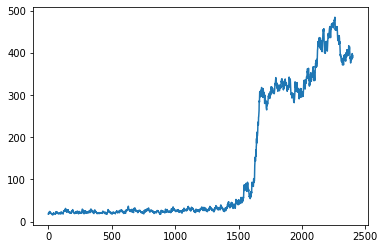

In [37]:


all_ep_r = []
for i in range(N_EPISODE):
    ep_r = 0
    # s = env.reset()[24:, :, :]
    s = env_easy.reset()
    # env.render()
    states, actions, rewards = [], [], []
    done = False
    t = 0
    life_index = 0
    life = np.empty(2)
    while done is False:
        a = agent.eval().action_select(torch.tensor(s, dtype=torch.float).unsqueeze(0))
        # s_, r, done, _ = env.step(a)
        s_, r, done, _ = env_easy.step(int(a))

        
        ep_r += r
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = s_

        t += 1  # 加完之后t为存储的个数

        if t % (BATCH + TIME_STEP) == 0:  # 括号里不减一是因为算delta还要算下一时刻的V
            
            states = torch.FloatTensor(np.array(states)).to(DEVICE)     # list里是ndarray的s，先全换成ndarray，再换成tensor，快很多很多
            actions = torch.tensor(actions[:agent.batch_size]).to(DEVICE)
            rewards = torch.tensor(rewards).to(DEVICE)
            
            delta = agent.delta_cal(rewards, states)
            targets = agent.target_cal(rewards)
            
            

            # 计算delta，截断版本的advantage
            agent.train().update(states, actions, delta, targets)  # 进行actor和critic网络的更新
            states, actions, rewards = [], [], []

    print('Episode {:03d} | Reward:{:.03f}'.format(i, ep_r))
    if i % 600 == 0:
        torch.save(agent.state_dict(),"/content/ppo_easy"+str(i)+".pth")
    if i == 0:
        all_ep_r.append(ep_r)
    else:
        all_ep_r.append(all_ep_r[-1] * 0.9 + ep_r * 0.1)  # 平滑

plt.plot(np.arange(len(all_ep_r)), all_ep_r)
plt.show()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive
